In [24]:
import os as os
import time as time
import numpy as np
import random as random
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as F_vision
import matplotlib.pyplot as plt
from torchvision.transforms import Grayscale

from torch.nn.functional import interpolate

from torch.utils import data
from torch.utils.data import Subset
from torchvision import transforms
from typing import Callable

In [25]:
def determine_device():
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available():
        device = "mps" # Apple M1

    print(f"We are using device: {device}")
    return device

In [26]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [27]:
BATCH_SIZE = 32 
LEARNING_RATE = 0.0005 # 0.001
WEIGHT_DECAY = 0.004 # 0.001
NUM_CLASSES = 5
NUM_WORKERS = 0
NUM_EPOCHS = 10
IMG_SZE = 256
INPUT_CHANNELS = 1
SEED = 42

DEVICE = determine_device()

DATA_DIR = './data/SolarPanel' if IN_COLAB else './data'
CATEGORIES = ['train', 'val', 'test']

We are using device: cpu


In [28]:
def set_seed(seed = 42):
    '''Sets a common seed for reproductibility purposes, so that the results are similar, every time you run this notebook.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

In [29]:
set_seed(SEED)

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
%cd /content/drive/MyDrive/MALDASC/project/

/content/drive/MyDrive/MALDASC/project


In [32]:
!unzip ./SolarPanel_imageSegmentation.zip

Archive:  ./SolarPanel_imageSegmentation.zip
replace SolarPanel_imageSegmentation/test/images/DJI_20220217142957_0035_T_JPG_jpg.rf.3919dd28a228273392fca09ba619e914.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: SolarPanel_imageSegmentation/test/images/DJI_20220217142957_0035_T_JPG_jpg.rf.3919dd28a228273392fca09ba619e914.npy  
  inflating: SolarPanel_imageSegmentation/test/images/DJI_20220217143101_0056_T_JPG_jpg.rf.54b667f5e30ff1054420bccb7b758bd3.npy  
  inflating: SolarPanel_imageSegmentation/test/images/DJI_20220217155021_0037_T_JPG_jpg.rf.b825d17dc73c127e8fc1cbd2f74d9f02.npy  
  inflating: SolarPanel_imageSegmentation/test/images/DJI_20220217155035_0042_T_JPG_jpg.rf.baeca3599025edf88cf07c3f6e9165e1.npy  
  inflating: SolarPanel_imageSegmentation/test/images/DJI_20220217155051_0047_T_JPG_jpg.rf.0aa3a800d73a25f5556577596189e6e1.npy  
  inflating: SolarPanel_imageSegmentation/test/images/DJI_20220217155212_0073_T_JPG_jpg.rf.06690f06aa7d843fa40daa20c373edff.npy  
  inflating

In [35]:
DATA_DIR = './SolarPanel_imageSegmentation'

In [36]:
def get_files(dataset_path, extension='.npy'):
  return [f for f in os.listdir(dataset_path) if os.path.isfile(os.path.join(dataset_path, f)) and f.endswith(extension)]

class MaskCorrection(object):
  """
  Correcting the masks of the OCT Dataset
    From: classes [0,1,2,3,4,5,6,7,8,9], where 9 represents fluid, 0 represents the empty space above, and 8 represents the empty space below
    To: class 0: background class, classes 1-7: represent retinal layers, and class 8: fluid
  """
  def __call__(self, mask):
    mask[mask == 0] = 0
    mask[mask == 4] = 4
    return mask

In [37]:
class SolarPanelData(data.Dataset):
    

    def __init__(self, dataset_path: str, mask_transform=None, joint_transform: Callable = None, image_transform: Callable = None, is_train=False):
      super(SolarPanelData, self).__init__()
      self.dataset_path = dataset_path
      self.mask_transform = mask_transform
      self.joint_transform = joint_transform
      self.image_transform = image_transform
      self.image_path = os.path.join(dataset_path, 'images')
      self.mask_path = os.path.join(dataset_path, 'masks')
      self.image_list = get_files(dataset_path=self.image_path, extension='.npy')
      self.is_train = is_train
     

    def __getitem__(self, idx):
      patient_file = self.image_list[idx]

      # load images and masks from .npy files (https://discuss.pytorch.org/t/loading-npy-files-using-torchvision/28481/3)
      img = torch.from_numpy(np.load(os.path.join(self.image_path, patient_file))).unsqueeze(0)
      mask = torch.from_numpy(np.load(os.path.join(self.mask_path, patient_file))).unsqueeze(0)

      # Convert img and mask to float tensors
      img = img.float()
      mask = mask.float()

      # Resize the image tensor
      #img = interpolate(img, size=(256, 256), mode='bilinear', align_corners=False)

      # apply mask transformation, e.g. self.mask_transform
      if self.mask_transform is not None:                               
        mask = self.mask_transform(mask)                              

      # apply joint transformations on both image and corresponding mask, i.e. self.joint_transform
      if self.joint_transform is not None:
          img = self.joint_transform(img)             
          mask = self.joint_transform(mask)     

      # functional transforms
      if self.is_train:
        img, mask = segmentation_transform(img, mask)

      # apply image transformation, i.e. self.image_transform
      if self.image_transform is not None:
          img = self.image_transform(img)                        

      return img, mask

    def __len__(self):
      return len(self.image_list)


def segmentation_transform(img, mask):
    
    i, j, h, w = transforms.RandomCrop.get_params(img, (IMG_SZE, IMG_SZE))
    img = F_vision.crop(img, i, j, h, w)
    mask = F_vision.crop(mask, i, j, h, w)
    
    if random.random() > 0.5:
        img = F_vision.hflip(img)
        mask = F_vision.hflip(mask)
        img = F_vision.vflip(img)
        mask = F_vision.vflip(mask)
        img = F_vision.rotate(img, angle=15)
        mask = F_vision.rotate(mask, angle=15)

    return img, mask

In [38]:
dataset_path = {x: os.path.join(DATA_DIR, x) for x in CATEGORIES}

In [39]:
print(dataset_path)

{'train': './SolarPanel_imageSegmentation/train', 'val': './SolarPanel_imageSegmentation/val', 'test': './SolarPanel_imageSegmentation/test'}


In [40]:
DATASET_MEAN = 46.3758/255.
DATASET_STD = 53.9434/255.

joint_transform = {
    'train': transforms.Compose([
        transforms.Resize([IMG_SZE, IMG_SZE]),
    ]),
    'val': transforms.Compose([
        transforms.Resize([IMG_SZE, IMG_SZE]),
    ]),
    'test': transforms.Compose([
        transforms.Resize([IMG_SZE, IMG_SZE]),
    ]),
}

image_transform= {
    'train': transforms.Compose([
        transforms.Normalize(DATASET_MEAN, DATASET_STD)
    ]),
    'val': transforms.Compose([
        transforms.Normalize(DATASET_MEAN, DATASET_STD)
    ]),
    'test': transforms.Compose([
        transforms.Normalize(DATASET_MEAN, DATASET_STD)
    ]),
}

In [41]:
print(joint_transform)

{'train': Compose(
    Resize(size=[256, 256], interpolation=bilinear, max_size=None, antialias=warn)
), 'val': Compose(
    Resize(size=[256, 256], interpolation=bilinear, max_size=None, antialias=warn)
), 'test': Compose(
    Resize(size=[256, 256], interpolation=bilinear, max_size=None, antialias=warn)
)}


In [42]:
dataset = {
    'train': SolarPanelData(dataset_path=dataset_path['train'], mask_transform=MaskCorrection(), joint_transform=joint_transform['train'], image_transform=image_transform['train'], is_train=True),     
    'val': SolarPanelData(dataset_path=dataset_path['val'], mask_transform=MaskCorrection(), joint_transform=joint_transform['val'], image_transform=image_transform['val']),
    'test': SolarPanelData(dataset_path=dataset_path['test'], mask_transform=MaskCorrection(), joint_transform=joint_transform['test'], image_transform=image_transform['test'])
}

In [43]:
print(dataset)

{'train': <__main__.SolarPanelData object at 0x7f846e9e7670>, 'val': <__main__.SolarPanelData object at 0x7f846e9e46a0>, 'test': <__main__.SolarPanelData object at 0x7f846e9e7b50>}


In [44]:
dataloaders = {
    'train': data.DataLoader(dataset['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS),
    'val': data.DataLoader(dataset['val'], batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS),
    'test': data.DataLoader(dataset['test'], batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
}

In [20]:
print(dataloaders)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7fb4dc7139a0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7fb4dc712920>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7fb4dc561300>}


In [53]:
def show_overlay(img, mask=None, alpha=0.5):
  plt.imshow(img, cmap='bone')
  if mask is not None:
    plt.imshow(mask, alpha=alpha)
  plt.axis('off')

In [54]:
def plot_batch(imgs, masks, num_samples):
  plt.figure(figsize=(5*num_samples, 5))
  for idx in range(num_samples):
    plt.subplot(1, 5, idx+1)
    img = imgs[idx, :].permute((1,2,0)).cpu().detach().numpy()*255.0
    mask = masks[idx, :].permute((1,2,0)).cpu().detach().numpy()*255.0
    show_overlay(img=img.squeeze(), mask=mask.squeeze())
  plt.show()

In [55]:
imgs, masks = next(iter(dataloaders['train']))

In [56]:
masks.shape, imgs.shape

(torch.Size([32, 1, 256, 256]), torch.Size([32, 1, 256, 256]))

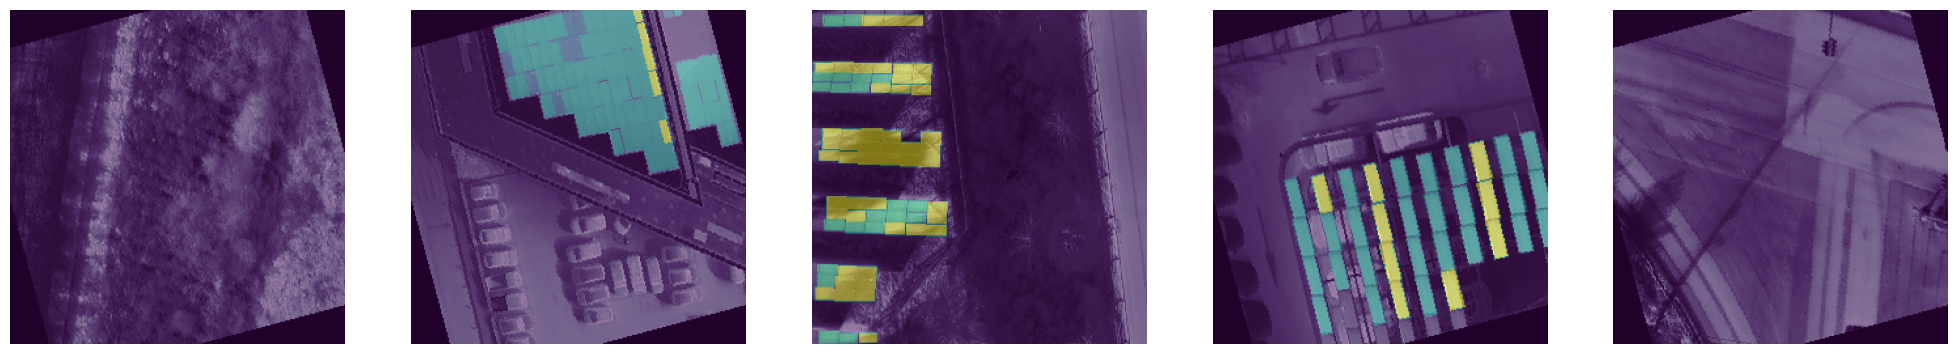

In [57]:
plot_batch(imgs, masks, num_samples=5)

In [59]:
class ConvolutionalBlock(nn.Module):
  """
  This class defines the convolutional block, consisting of a double convolution layer: [Conv - BN - ReLU] -> [Conv - BN - ReLU]
  Hint: Have a look at nn.Conv2d( ), nn.BatchNorm2d( ), and nn.ReLU( )
  
  Parameters:
    in_channels: number of input channels
    out_channels: number of output channels
    kernel_size: kernel size used during convolution
    padding: padding value
  """
  def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding) # ibgupta: first conv2D layer has 1 input channel (gray-scale image)
    self.bn1 = nn.BatchNorm2d(out_channels)     # ibgupta: output from first conv2D layer is fed as input to BN layer 1
    self.relu  = nn.ReLU(inplace=True) # https://discuss.pytorch.org/t/whats-the-difference-between-nn-relu-and-nn-relu-inplace-true/948
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding)
    self.bn2 = nn.BatchNorm2d(out_channels)
      
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    return x

In [61]:
# Creating an image with random values
x_in      = torch.randn(1, INPUT_CHANNELS, IMG_SZE, IMG_SZE)

# Initialising the Convolutional Block
enc_block = ConvolutionalBlock(in_channels=INPUT_CHANNELS, out_channels=64)
x_conv    = enc_block(x_in)

print(x_in.shape)
print(x_conv.shape)

torch.Size([1, 1, 256, 256])
torch.Size([1, 64, 256, 256])


In [63]:
class UpsamplingBlock(nn.Module):
  
  def __init__(self, in_channels, out_channels, scale_factor=2):
      super().__init__()
      self.up = nn.Upsample(scale_factor=scale_factor)
      self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1)

  def forward(self, x):
    x = self.up(x)
    x = self.conv(x)
    return x

In [64]:
# Creating an image with random values
x_in      = torch.randn(1, 128, 16, 16)

# Initialising the UpsamplingBlock
up_block = UpsamplingBlock(in_channels=128, out_channels=128, scale_factor=2)
x_up    = up_block(x_in)

print(x_in.shape)
print(x_up.shape)

torch.Size([1, 128, 16, 16])
torch.Size([1, 128, 32, 32])


In [65]:
class OutConv(nn.Module):
  
    def __init__(self, in_channels, num_classes, kernel_size=1, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=num_classes, kernel_size=kernel_size, padding=padding)

    def forward(self, x):
        x = self.conv(x)
        return x

In [66]:
# Creating an image with random values
x_in      = torch.randn(1, INPUT_CHANNELS, IMG_SZE, IMG_SZE)

# Initialising the UpsamplingBlock
out_layer = OutConv(in_channels=INPUT_CHANNELS, num_classes=NUM_CLASSES)
x_out     = out_layer(x_in)

print(x_in.shape)
print(x_out.shape)

torch.Size([1, 1, 256, 256])
torch.Size([1, 5, 256, 256])


In [67]:
class Encoder(nn.Module):

    def __init__(self, channels=(1,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.Sequential(
            ConvolutionalBlock(channels[0], channels[1]),
            ConvolutionalBlock(channels[1], channels[2]),
            ConvolutionalBlock(channels[2], channels[3]),
            ConvolutionalBlock(channels[3], channels[4]),
            ConvolutionalBlock(channels[4], channels[5]),
        )
        self.pool     = nn.MaxPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        x_skip = []
        for block in self.enc_blocks:
            x = block(x)
            x_skip.append(x)
            x = self.pool(x)
        return x_skip

In [68]:
# Creating an image with random values 
x_in    = torch.randn(1, INPUT_CHANNELS, IMG_SZE, IMG_SZE) # [BATCH_SIZE, CHANNELS, HEIGHT, WIDTH]

# Initialising the Encoder Class
encoder = Encoder(channels=(INPUT_CHANNELS, 64,128,256,512,1024))
x_skip = encoder(x_in)

for skip in x_skip: print(skip.shape)

torch.Size([1, 64, 256, 256])
torch.Size([1, 128, 128, 128])
torch.Size([1, 256, 64, 64])
torch.Size([1, 512, 32, 32])
torch.Size([1, 1024, 16, 16])


In [69]:
class Decoder(nn.Module):
   

    def __init__(self, channels=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.channels   = channels
        self.upconvs    = nn.Sequential(
            UpsamplingBlock(channels[0], channels[1]),
            UpsamplingBlock(channels[1], channels[2]),
            UpsamplingBlock(channels[2], channels[3]),
            UpsamplingBlock(channels[3], channels[4])
        ) # initialise the different UpsamplingBlocks
        self.dec_blocks = nn.Sequential(
            ConvolutionalBlock(channels[0], channels[1]),
            ConvolutionalBlock(channels[1], channels[2]),
            ConvolutionalBlock(channels[2], channels[3]),
            ConvolutionalBlock(channels[3], channels[4])
        ) # initialise the different Decoding Blocks
        
    def forward(self, x, x_skip):
        # Following the U-Net architecture, you should upsample the features, crop them to the proper size, 
        # concatenate with the skip connections and apply convolutional layers.
        for ii in range(len(self.channels)-1):
            x = self.upconvs[ii](x)
            x_skip_cropped = self.crop(x_skip[ii], x)
            x = torch.cat((x, x_skip_cropped), 1)
            x = self.dec_blocks[ii](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

In [70]:
# Creating an image with random values
x_in = torch.randn(1, 1024, 16, 16)

# Initialising the Decoder Class
decoder = Decoder()
x_dec = decoder(x_in, x_skip[::-1][1:])

print(x_in.shape)
print(x_dec.shape)

torch.Size([1, 1024, 16, 16])
torch.Size([1, 64, 256, 256])


In [71]:
class UNet(nn.Module):
 
    def __init__(self, num_classes=1, enc_channels=(1,64,128,256,512,1024), dec_channels=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.num_classes  = num_classes
        self.enc_channels = enc_channels
        self.dec_channels = dec_channels
        self.encoder      = Encoder(channels=enc_channels) # initialise the encoder
        self.decoder      = Decoder(channels=dec_channels) # initialise the decoder
        self.head         = OutConv(in_channels=dec_channels[len(dec_channels)-1], num_classes=num_classes) # initialise the last convolutional layer

    def forward(self, x):
        x_enc  = self.encoder(x)
        x_enc_inverse = x_enc[::-1]
        x_dec  = self.decoder(x_enc_inverse[0], x_enc_inverse[1:])
        logits = self.head(x_dec)

        if self.num_classes == 1:
            probas = torch.sigmoid(logits)
        elif self.num_classes > 1:
            probas = F.softmax(logits, dim=1)

        return logits, probas

In [72]:
x_in = torch.randn(1, INPUT_CHANNELS, IMG_SZE, IMG_SZE)
unet = UNet()
x_logits, x_probas = unet(x_in)
print(x_in.shape)
print(x_logits.shape)

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])


In [73]:
model = UNet(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
print(model)

UNet(
  (encoder): Encoder(
    (enc_blocks): Sequential(
      (0): ConvolutionalBlock(
        (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ConvolutionalBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): ConvolutionalBlock(
        (conv1): Conv2d(128, 256, kernel_size=(

In [74]:
loss_fn = nn.CrossEntropyLoss()

def NetworkLoss(loss_fn, logits, probas, masks, num_classes, weight=1):
    masks = masks.squeeze(1) # [32, 1, 256, 256] -> [32, 256, 256] according to https://stackoverflow.com/questions/67322848/unet-with-crossentropy-loss-function/67323463#67323463
    # print(f"masks.shape: {masks.shape}, logits.shape: {logits.shape}, probas.shape: {probas.shape}") # masks.shape: torch.Size([32, 256, 256]), logits.shape: torch.Size([32, 9, 256, 256])

    # ce_loss = F.cross_entropy(logits, masks.long()) # compute cross entropy loss using the outputs from the model and the corresponding masks
    ce_loss = loss_fn(logits, masks.long()) # compute cross entropy loss using the outputs from the model and the corresponding masks

    predicted_labels = torch.argmax(probas, dim=1)
    # print(f"predicted_labels.shape: {predicted_labels.shape}, masks.shape: {masks.shape}")

    acc = (predicted_labels == masks.long()).sum().item() / masks.numel() # compute the model's accuracy
    return ce_loss, acc

In [75]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [76]:
def compute_accuracy_and_loss(model, dataloader, loss_fn, num_classes, device):
    model.eval()

    num_samples = len(dataloader)
    set_loss = 0.
    set_acc = 0.

    predictions_arr = []
    targets_arr  = []

    for ii, (imgs, masks) in enumerate(dataloader):
            
        imgs = imgs.to(device) # x to device
        masks = masks.to(device) # y to device

        logits, probas = model(imgs) # forward propagation z=logits, a=f(z)

        # compute model loss and accuracy
        loss, acc = NetworkLoss(loss_fn, logits, probas, masks, num_classes)
        set_loss += loss.item()
        set_acc += acc

    return set_loss/num_samples, set_acc/num_samples * 100

In [77]:
def train(model, num_epochs, train_loader, valid_loader, loss_fn, num_classes, device, scheduler=None, load_last_checkpoint=False):

  minibatch_cost = []
  train_acc_lst, valid_acc_lst = [], []
  train_loss_lst, valid_loss_lst = [], []

  lowest_loss = np.inf
  best_acc = 0

  start_time = time.time()

  # load model weights if they exist
  if load_last_checkpoint and os.path.isfile('./checkpoint/ckpt.pth'):
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    model.load_state_dict(checkpoint['model'])
    print('Loaded model weights from file.')

  for epoch in range(num_epochs):

      model.train()

      #for batch_idx, data in enumerate(train_loader):
      for batch_idx, (imgs, masks) in enumerate(train_loader):
          
          imgs = imgs.to(device) 
          masks = masks.to(device)
              
          # forward-propagation
          logits, probas = model(imgs)

          # compute cost function
          cost, acc = NetworkLoss(loss_fn, logits, probas, masks, num_classes)

          # clean gradients
          optimizer.zero_grad()
          
          # compute derivatives
          cost.backward()

          # append minibatch cost
          minibatch_cost.append(cost.item())
          
          # update model parameters
          optimizer.step() # w = w - learning_rate * partial_deriv_error
          
          # logging results
          if not batch_idx % 50:
              print('Epoch: %05d/%05d | Batch %05d/%05d | Batch Cost: %.4f | Batch Acc: %.2f%%' 
                    %(epoch+1, num_epochs, batch_idx, 
                      len(train_loader), cost, acc * 100))
              
      with torch.set_grad_enabled(False):
          train_loss, train_acc  = compute_accuracy_and_loss(model=model, dataloader=train_loader, loss_fn=loss_fn, num_classes=num_classes, device=device)
          valid_loss, valid_acc  = compute_accuracy_and_loss(model=model, dataloader=valid_loader, loss_fn=loss_fn, num_classes=num_classes, device=device)

          print('Epoch: %05d/%05d | Train cost: %.4f | Valid cost: %.4f | Train acc.: %.4f%% | Val.acc.: %.4f%%' % (
                epoch+1, num_epochs, 
                train_loss,
                valid_loss,
                train_acc,
                valid_acc))
          
          train_acc_lst.append(train_acc)
          valid_acc_lst.append(valid_acc)
          train_loss_lst.append(train_loss)
          valid_loss_lst.append(valid_loss)

          if valid_acc > best_acc:
            best_acc = valid_acc
            print('Better model: saving to disk.')
            state = {
              'model': model.state_dict(),
              'best_acc': best_acc,
              'epoch': epoch,
              'optimizer': optimizer.state_dict(),
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, './checkpoint/ckpt.pth')
          
      print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

      if scheduler:
        lr_before = optimizer.param_groups[0]['lr']
        scheduler.step(valid_acc)
        lr_after = optimizer.param_groups[0]['lr']
        if lr_before != lr_after:
          print(f"Learning rate changed from {lr_before} to {lr_after}")

  print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

  return minibatch_cost, train_loss_lst, valid_loss_lst, train_acc_lst, valid_acc_lst

In [78]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

In [ ]:
minibatch_cost, train_loss_lst, valid_loss_lst, train_acc_lst, valid_acc_lst = train(model, NUM_EPOCHS, dataloaders['train'], dataloaders['val'], loss_fn, NUM_CLASSES, DEVICE, scheduler, load_last_checkpoint=False)

In [ ]:
plt.plot(range(len(train_loss_lst)), (train_loss_lst), color='b', linewidth=4, label='Training Loss')
plt.plot(range(len(valid_loss_lst)), (valid_loss_lst), color='r', linewidth=4, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss values', fontsize=20)
plt.ylabel('Cross entropy', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.grid()
plt.show()

In [ ]:
plt.plot(range(len(train_acc_lst)), (train_acc_lst), color='b', linewidth=4, label='Training Acc')
plt.plot(range(len(valid_acc_lst)), (valid_acc_lst), color='r', linewidth=4, label='Validation Acc')
plt.legend(loc='upper right')
plt.title('Accuracy values', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.grid()
plt.show()

In [ ]:
# load model weights if they exist
if os.path.isfile('./checkpoint/ckpt.pth'):
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    model.load_state_dict(checkpoint['model'])
    print('Loaded model weights from file.')

model.eval()

None

In [ ]:
test_loss, test_acc  = compute_accuracy_and_loss(model=model, dataloader=dataloaders['test'], loss_fn=loss_fn, num_classes=NUM_CLASSES, device=DEVICE)

In [ ]:
print(test_loss)

In [ ]:
print(test_acc)

In [ ]:
# Visualize the segmentation results on the test dataset. You don't need to change anything below
for batch_i, (imgs, masks) in enumerate(dataloaders['test']):

    for j in range(len(imgs)):
        logits, probas = model(imgs.to(DEVICE)[j:j+1])

        pred_mask = torch.argmax(probas, axis=1).cpu().detach().numpy()[0]
        im = np.moveaxis(imgs.to(DEVICE)[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)
        gt_mask = masks[j]

        plt.figure(figsize=(12,12))

        plt.subplot(1,3,1)
        im = np.moveaxis(imgs.to(DEVICE)[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)
        plt.imshow(im.squeeze())

        plt.subplot(1,3,2)
        plt.imshow(gt_mask.squeeze())

        plt.subplot(1,3,3)
        plt.imshow(pred_mask.squeeze())
        plt.show()